In [21]:
# Imports
import math

from argparse import ArgumentParser

import matplotlib.pyplot as plt
import numpy as np
import PIL
import pyvista as pv
import torch

from scipy.spatial.transform import Rotation as R

from arguments import ModelParams, PipelineParams, OptimizationParams
from gaussian_renderer import render
from scene import GaussianModel
from scene.cameras import Camera
from scene.dataset_readers import fetchPly
from utils.general_utils import PILtoTorch

In [22]:
# Setup some basic args without actually passing input
parser = ArgumentParser(description="Training script parameters")
lp = ModelParams(parser)
op = OptimizationParams(parser)
pp = PipelineParams(parser)
parser.add_argument("--ip", type=str, default="127.0.0.1")
parser.add_argument("--port", type=int, default=6009)
parser.add_argument("--debug_from", type=int, default=-1)
parser.add_argument("--detect_anomaly", action="store_true", default=False)
parser.add_argument("--test_iterations", nargs="+", type=int, default=[7_000, 30_000])
parser.add_argument("--save_iterations", nargs="+", type=int, default=[7_000, 30_000])
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--checkpoint_iterations", nargs="+", type=int, default=[])
parser.add_argument("--start_checkpoint", type=str, default=None)
args = parser.parse_args("")
args.save_iterations.append(args.iterations)

dataset = lp.extract(args)
training_args = op.extract(args)
pipe = pp.extract(args)

In [23]:
# Load a .ply dataset as a Gaussian model
sh_degree = 3
gaussians = GaussianModel(sh_degree)

ply_path = "data/fuel.ply"
pcd = fetchPly(ply_path)

spatial_lr_scale = 4.982904243469239
gaussians.create_from_pcd(pcd, spatial_lr_scale)

gaussians.training_setup(training_args)

Number of points at initialisation :  1176


In [24]:
def qvec2rotmat(qvec):
    return np.array(
        [
            [
                1 - 2 * qvec[2] ** 2 - 2 * qvec[3] ** 2,
                2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
                2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2],
            ],
            [
                2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
                1 - 2 * qvec[1] ** 2 - 2 * qvec[3] ** 2,
                2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1],
            ],
            [
                2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
                2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
                1 - 2 * qvec[1] ** 2 - 2 * qvec[2] ** 2,
            ],
        ]
    )


def fov2focal(fov, pixels):
    return pixels / (2 * math.tan(fov / 2))

In [25]:
# Instantiate the plotter once
def init_pv_plotter(path, width, height):
    mesh = pv.read(path)
    plotter = pv.Plotter(off_screen=True)
    plotter.add_mesh(mesh, show_scalar_bar=False, cmap=plt.cm.coolwarm_r)
    plotter.window_size = [width, height]
    return plotter


# Just used for getting the VTK matrices into a ndarray
def arrayFromVTKMatrix(vmatrix):
    from vtk import vtkMatrix4x4
    from vtk import vtkMatrix3x3
    import numpy as np

    if isinstance(vmatrix, vtkMatrix4x4):
        matrixSize = 4
    elif isinstance(vmatrix, vtkMatrix3x3):
        matrixSize = 3
    else:
        raise RuntimeError("Input must be vtk.vtkMatrix3x3 or vtk.vtkMatrix4x4")
    narray = np.eye(matrixSize).astype(np.float32)
    vmatrix.DeepCopy(narray.ravel(), vmatrix)
    return narray


# Generates a new Camera() object
def get_new_camera(plotter, seed):
    np.random.seed(seed)

    camera = plotter.camera

    # Set a new random camera position along a sphere centered on the model
    current_position = np.array(camera.position)
    focal_point = np.array(camera.focal_point)

    radius = np.linalg.norm(current_position - focal_point)
    theta = np.random.uniform(0, np.pi)
    phi = np.random.uniform(0, 2 * np.pi)

    x = focal_point[0] + radius * np.sin(theta) * np.cos(phi)
    y = focal_point[1] + radius * np.sin(theta) * np.sin(phi)
    z = focal_point[2] + radius * np.cos(theta)
    camera.position = (x, y, z)

    # Render the model, convert it to a PIL Image
    image_array = PIL.Image.fromarray(plotter.screenshot(return_img=True))

    resized_image_rgb = PILtoTorch(image_array, image_array.size, "cuda")
    gt_image = resized_image_rgb[:3, ...]

    loaded_mask = None
    if resized_image_rgb.shape[1] == 4:
        loaded_mask = resized_image_rgb[3:4, ...]

    # My attempt to produce the R and T variables that Camera expects:
    # R appears to be the camera's rotation matrix
    # T appears to be the camera's position

    # Idea: directly use the matrices that VTK Camera provides
    # They are way different than what Camera() ends up with.
    # Maybe just to extract the R and T?

    # testing = arrayFromVTKMatrix(camera.GetViewTransformMatrix())
    # rotation = testing[:3, :3].T
    # translation = testing[:3, 3]

    # Idea: take the pyvista camera rotation values and produce a rotation matrix directly
    azimuth = np.radians(camera.azimuth)
    elevation = np.radians(camera.elevation)
    roll = np.radians(camera.roll)

    rotation = R.from_euler("zyx", [azimuth, roll, elevation]).as_matrix().T
    translation = camera.position

    # Attempt to produce vertical and horizontal FoV values, in radians

    # FovX = fov2focal(camera.view_angle, width)
    # FovY = fov2focal(camera.view_angle, height)

    # Convert FovX to radians
    # FovX = math.radians(camera.view_angle)

    # # Calculate FovY in radians using the aspect ratio (width/height)
    # FovY = 2 * math.atan((height / width) * math.tan(FovX / 2))

    width = plotter.window_size[0]
    height = plotter.window_size[1]

    FovY = np.radians(camera.view_angle)
    FovX = 2 * math.atan(width / height) * math.tan(FovY / 2)

    # Used for centering? 0 seems ok based on the bicycle dataset
    cx = 0
    cy = 0

    # cx = width / 2
    # cy = height / 2

    # cx = (cx - width / 2) / width * 2
    # cy = (cy - height / 2) / height * 2

    plotter.close()

    # Instantiate a new Camera object using these computed values
    new_camera = Camera(
        colmap_id=1,
        R=rotation,
        T=translation,
        FoVx=FovX,
        FoVy=FovY,
        cx=cx,
        cy=cy,
        image=gt_image,
        gt_alpha_mask=loaded_mask,
        image_name="",
        uid=0,
        data_device="cuda",
    )

    # Debug prints

    # print("new_camera")
    # print(f"azimuth={azimuth}")
    # print(f"elevation={elevation}")
    # print(f"roll={roll}")
    # print(f"view_angle={camera.view_angle}")
    # print(f"uid={new_camera.uid}")
    # print(f"colmap_id={new_camera.colmap_id}")
    # print(f"R={new_camera.R}")
    # print(f"T={new_camera.T}")
    # print(f"FoVx={new_camera.FoVx}")
    # print(f"FoVy={new_camera.FoVy}")
    # print(f"cx={new_camera.cx}")
    # print(f"cy={new_camera.cy}")
    # print(f"image_name={new_camera.image_name}")
    # print(f"data_device={new_camera.data_device}")
    # print(f"image_width={new_camera.image_width}")
    # print(f"image_height={new_camera.image_height}")
    # print(f"zfar={new_camera.zfar}")
    # print(f"znear={new_camera.znear}")
    # print(f"trans={new_camera.trans}")
    # print(f"scale={new_camera.scale}")
    # print(f"world_view_transform={new_camera.world_view_transform}")
    # print(f"projection_matrix={new_camera.projection_matrix}")
    # print(f"full_proj_transform={new_camera.full_proj_transform}")
    # print(f"camera_center={new_camera.camera_center}")
    # print(f"focal_point={camera.focal_point}")
    # print(f"focal_disk={camera.GetFocalDisk()}")
    # print(f"window_center={camera.GetWindowCenter()}")
    # print(
    #     f"projection_transform_matrix={arrayFromVTKMatrix(camera.GetProjectionTransformMatrix(plotter.renderer))}"
    # )
    return new_camera

In [26]:
# Seeded random camera values, was supposed to help with debugging
seed = 0

# Can change the image resolution to whatever you'd like, but 1080p is fast
width = 1920
height = 1080

plotter = init_pv_plotter(ply_path, width, height)

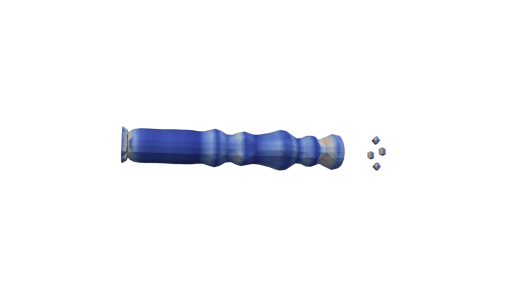

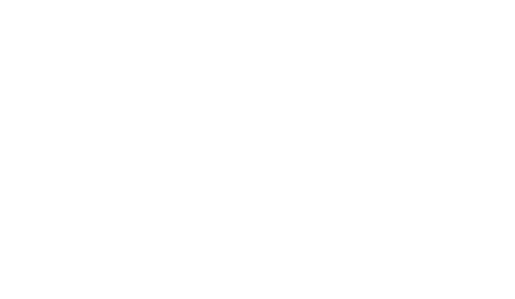

In [27]:
# Generate a new synthetic viewpoint and feed the camera parameters to the Gaussian renderer
bg_color = [1, 1, 1]
bg = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

viewpoint_cam = get_new_camera(plotter, seed)
render_pkg = render(viewpoint_cam, gaussians, pipe, bg)
gaussian_image = render_pkg["render"]

# Original Pyvista render (ground truth)
plt.imshow(viewpoint_cam.original_image.cpu().detach().numpy().transpose(1, 2, 0))
plt.axis("off")
plt.show()

# Gaussian render (usually the model isn't in the scene)
plt.imshow(gaussian_image.cpu().detach().numpy().transpose(1, 2, 0))
plt.axis("off")
plt.show()